<h1>Popular Steam Game Sentiment Analysis</h1>
Citation </br>
Antoni Sobkowicz. (2017). Steam Review Dataset (2017) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1000885

License
CC BY NC 4.0|

# 1. Install & Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
# %pip install stopwords
# %pip install flair
# %pip install nltk
# %pip install swifter
# %pip install wordcloud
# %pip install pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download()

from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
# from scikitplot.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 2. Import Steam Games Review Dataset

app_id       -> Game ID <br/>
app_name     -> Game Name <br/>
review_text  -> Review text <br/>
review_score -> Review Sentiment: whether the game the review recommends the game or not. [1: Yes, -1: No, 0: None] <br/>
review_votes -> Review vote  : whether the review was recommended by another user or not. [1: Yes, 0: No] <br/>

In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [5]:
# Since the dataset contains 6.4m data, I planned to 
# scale down the dataset to <100,000 entries.

# Check the amount of review from rach game
dataset['app_name'].value_counts(ascending=False, dropna=True).head()


PAYDAY 2    88973
DayZ        88850
Terraria    84828
Rust        77037
Dota 2      73541
Name: app_name, dtype: int64

In [6]:
# Since Dota 2 has the most review and contains 88973 entries, 
# I decided to make sentiment analysis on the chosen game - PAYDAY 2.

#Create dota2 dataframe
df = dataset[dataset['app_name'] == 'Dota 2'].reset_index(drop=True)
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [7]:
# Generate dota2_dataset.csv file that help to load faster in further use
# dota2_df.to_csv('dota2_dataset.csv', index=False)

## Load payday2_dataset.csv dataset

In [8]:
df = pd.read_csv('dota2_dataset.csv')
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [9]:
# Check the shape of the dataset: Use the shape attribute of the DataFrame to check the number of rows and columns in the dataset.
print('Dataset shape:', df.shape)

Dataset shape: (73541, 5)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73541 entries, 0 to 73540
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        73541 non-null  int64 
 1   app_name      73541 non-null  object
 2   review_text   73433 non-null  object
 3   review_score  73541 non-null  int64 
 4   review_votes  73541 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [11]:
df['review_text'] = df['review_text'].astype('str')

# 3. Data Cleaning For Sentiment Processing
## Basic Cleaning

In [12]:
# Remove Null values
df2 = df.dropna(inplace=False)

# Remove Duplicate Values
df2 = df.drop_duplicates(keep='first')

In [13]:
df2.shape


(50190, 5)

After basic cleaning, there are 50190 entries left with 5 coloumns.

## Enhanced Cleaning

In [14]:
# Define required cleaning function
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')

# Remove hyperlinks and markup
def removeHyperlink(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result
 
# Remove Numeric
def remove_num(text):
   output = re.sub(r'\d+', '', text)
   return output

# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)

# Remove Symbol
def remove_symbols(text):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return cleaned_string

# Remove Punctuation
def remove_punctuation(text):
    final = "".join(u for u in text if u not in (
        "?", ".", ";", ":",  "!", '"', ','))
    return final

# Remove Stopwords
def remove_stopword(text):
    stop = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    lemma = WordNetLemmatizer()

    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

# Unify Whitespaces
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text)
    return cleaned_string

# Normalize words using Stemming
def Stemming(text):
   stem = []
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem = ' '.join(stemmed_word)
   return stem

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def cleaning(df, review):
    df[review] = df[review].apply(removeHyperlink)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

cleaning(df2, 'review_text')
df2[['review_text']].head(10)

,review_text
0,caus anxieti problem low self esteem tourett s...
1,game taught divers cultur small littl corner u...
2,like roulett fun turn russian
3,dota mani peopl speak languag mani peopl play ...
4,side effect includ explos diarrhea hatr human ...
5,hour fun select russia want play today
6,game murder tree kill ancient creatur chill ca...
7,dota start game ruin social life spend everi d...
8,play game thought brazillian bad soccer
9,game made racist toward speak languag english ...


# 4. EDA (Analysis and Visualization)

## Distribution of Reviews in Each Sentiment

In [16]:
sentiment_counts = df2.groupby('review_score').count(
)['review_text'].reset_index().sort_values(by='review_text', ascending=False)

sentiment_counts

,review_score,review_text
1,1,42369
0,-1,7821


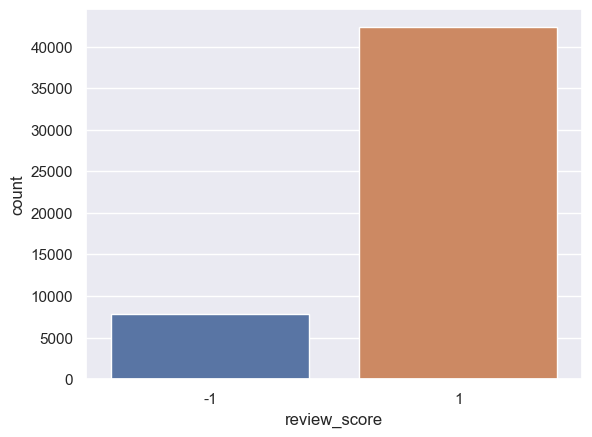

In [17]:
# We will see the visualization of it.
sns.set_theme(style='darkgrid')
sns.countplot(x='review_score',data=df2);

### Conclude: Positive > Negative
We can see that there are more positive sentiment reviews than negative sentiment reviews.

## WordCloud of Our Review Text

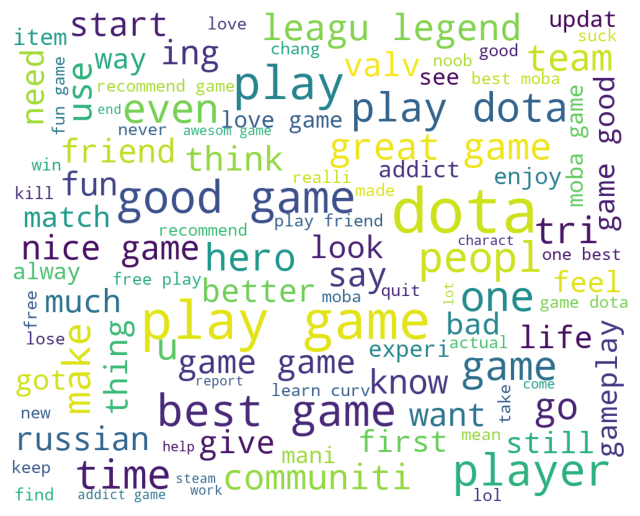

In [18]:
txt = ' '.join(df2['review_text'].values.tolist())

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 800
            ).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### WordCloud of Each Sentiment Review Text

In [19]:
positive = df2[df2['review_score']==1]
negative = df2[df2['review_score']==-1]

#### Positive Sentiment Reviews

<Figure size 1500x800 with 0 Axes>

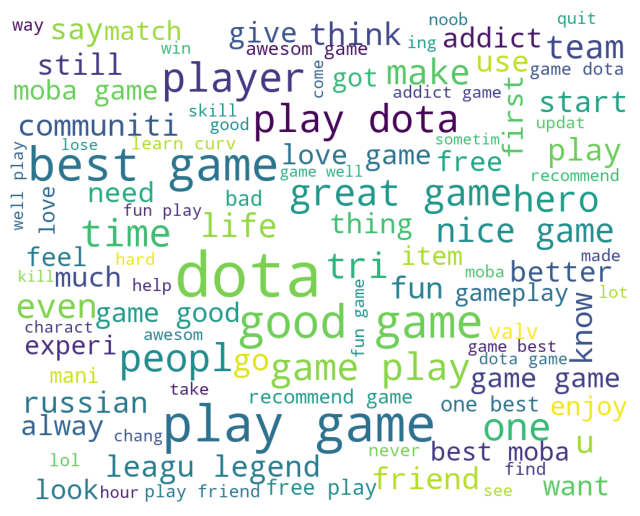

In [20]:
# Positive Sentiment Reviews
txt = ' '.join(positive['review_text'].values.tolist())
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
    background_color='white',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800
).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see that for postive sentiment review, the most common words are 'good', 'great', 'best', etc as shown in wordcloud above.

#### Negative Sentiment Reviews

<Figure size 1500x800 with 0 Axes>

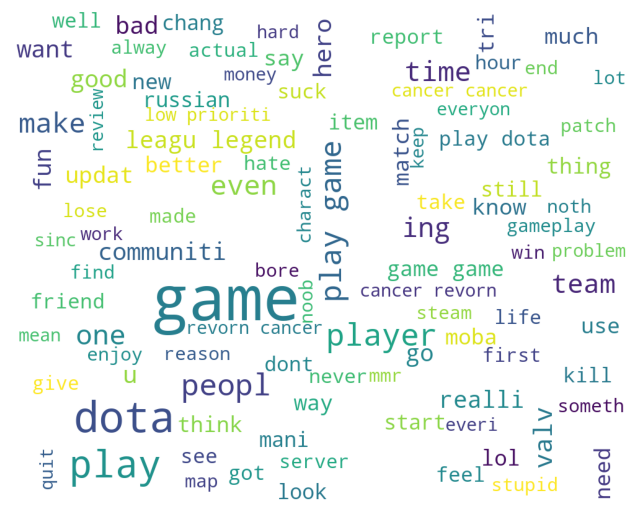

In [21]:
txt = ' '.join(negative['review_text'].values.tolist())
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
    background_color='white',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800
).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

And we can see that for negative sentiment review, the most common words are 'bad' etc as shown in wordcloud above. 

## Distribution of Number of Review Words

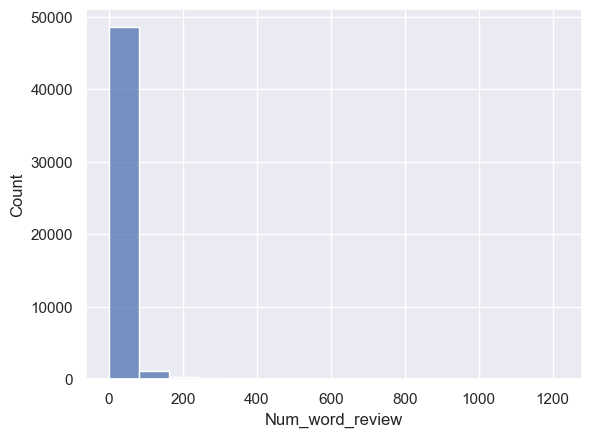

In [22]:
df_Num_word_review = df2.copy()
df_Num_word_review['Num_word_review'] = df2['review_text'].apply(
    lambda x: len(str(x).split()))

sns.histplot(data=df_Num_word_review, x="Num_word_review",bins=15);

### Observation on Result
As we can see that most of our review texts contain 1-100 words.

## Distribution of Words in All Review Texts

In [23]:
df2['temp_list'] = df2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='autumn')

,Common_words,count
0,game,54203
1,play,24024
2,dota,16408
3,like,8404
4,good,7974
5,get,7399
6,best,6550
7,time,6058
8,fun,5477
9,player,5233


# 5. Creating Bag of Words and Text Classifier Model
## Creating pipeline for tokenizing and modelling

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

# Split the dataset into input (X) and target (y)
X = df2['review_text'].values
y = df2['review_score'].values

# Data Tranformation using CountVectorizer
countVect = CountVectorizer(stop_words="english", max_features=5000)
X_transform = countVect.fit_transform(X)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_transform, y, random_state=40, test_size=0.20)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=23, n_jobs=-1)),
])

# Fit the pipeline on the training data
base_model = pipeline.fit(X_train, y_train)

# Make predictions on the testing data
predictions = base_model.predict(X_test)

## Test Model's Performance

Classification Report: 
               precision    recall  f1-score   support

           1       0.87      0.98      0.92      8446
          -1       0.68      0.25      0.36      1592

    accuracy                           0.86     10038
   macro avg       0.78      0.61      0.64     10038
weighted avg       0.84      0.86      0.83     10038



Confusion Matrix:


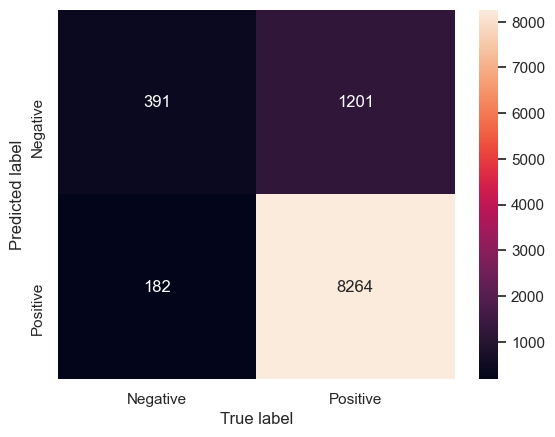

TN - True Negative 391
FP - False Positive 1201
FN - False Negative 182
TP - True Positive 8264


Accuracy Rate: 0.8622235505080693
F1-Score     : 0.6419929022935187
ROC-AUC      : 0.6120271764934071


In [25]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def Performance(y_test,ypred):
    print('Classification Report: \n', classification_report(
        y_test, ypred, labels=[1, -1]))
    print('\n')
    
    # Plot Confusion Matrix
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test, ypred), annot=True, fmt='g', xticklabels=[
                'Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    
    cfmat = confusion_matrix(y_test,ypred)
    print('TN - True Negative {}'.format(cfmat[0, 0]))
    print('FP - False Positive {}'.format(cfmat[0, 1]))
    print('FN - False Negative {}'.format(cfmat[1, 0]))
    print('TP - True Positive {}'.format(cfmat[1, 1]))
    
    print('\n')
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('F1-Score     : {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC      : {}'.format(roc_auc_score(y_test,ypred)))

Performance(y_test,predictions)

We see from above confusion matrix that our model has accuracy of 86.5 % and F1-Score of 0.64. It is not good because our data is highly imbalanced. Our model has high accuracy because it computes accuracy of prediction on majority class. After putting our attention to F1-Score, we can understand that our data is poorly at predicting negative class. 

We also have ROC-AUC score of 0.61. So there is a high chance that the our text classifier model WILL NOT be able to distinguish the positive sentiment class values from the negative sentiment class values.


## Imbalanced Data Classes Handling

Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({-1: 30000, 1: 30000})
Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.90      0.94      8446
          -1       0.63      0.92      0.75      1592

    accuracy                           0.90     10038
   macro avg       0.81      0.91      0.84     10038
weighted avg       0.93      0.90      0.91     10038



Confusion Matrix:


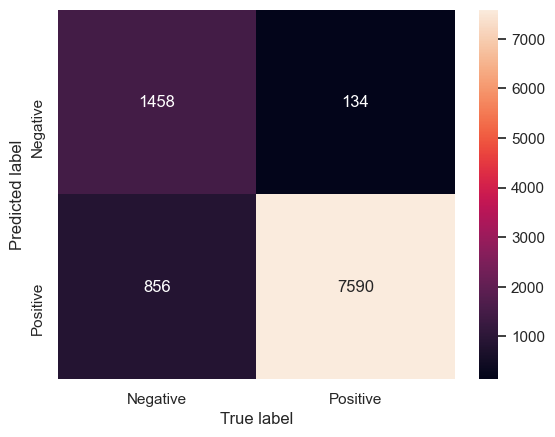

TN - True Negative 1458
FP - False Positive 134
FN - False Negative 856
TP - True Positive 7590


Accuracy Rate: 0.9013747758517633
F1-Score     : 0.8426596445029625
ROC-AUC      : 0.9072396971835259


In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

# Resample Data
over = SMOTE(sampling_strategy={-1: 30000})
under = RandomUnderSampler(sampling_strategy={1: 30000})
pipeline_imbalance = PL(steps=[('over', over), ('under', under)])
X_Resample, y_Resample = pipeline_imbalance.fit_resample(X_transform, y)

print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",
      Counter(y_Resample))

# Apply Resample Balanced Data to train_test_split
X_train_Balanced, X_test_Balanced, y_train_Balanced, y_test_Balanced = train_test_split(
    X_Resample, y_Resample, random_state=23, test_size=0.20)

# Define the pipeline
pipeline2 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=23, n_jobs=10)),
])

# Fit the pipeline on the training data
model2 = pipeline2.fit(X_train_Balanced, y_train_Balanced)

# Evaluation on original data
predictions2 = model2.predict(X_test)
Performance(y_test, predictions2)

Now we got better model after training it on oversampling and undersampling data. We got model with accuracy of 88.7% and F1-Score of 0.83.
We also have ROC-AUC score of 0.9. So there is a high chance that the our text classifier model WILL be able to distinguish the positive sentiment class values from the negative sentiment class values on larger data.

Since the score is good, we start working on gridsearch, by addding RandomForestClassifier, SVC, and MultinomialNB to identify the best model

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score

# Define the pipelines
pipeline_rf = PL([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=23, n_jobs=5)),
])

pipeline_svc = PL([
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(random_state=23)),
])

pipeline_mnb = PL([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Define hyperparameters to tune with GridSearchCV
rf_param_grid = [{
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10, 15],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2']}]

svm_param_grid = [{
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10]}]

mnb_param_grid = [{
    'clf__alpha' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}]

# Define Cross Validation with KFold
cv = KFold(n_splits=5, shuffle=True, random_state=23)

scoring = ['accuracy', 'f1', make_scorer(roc_auc_score)]

# Setup all models GridSearchCV
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=rf_param_grid,
                              scoring='accuracy',
                              cv=cv,
                              verbose=2, n_jobs=5, refit='roc_auc')

grid_search_svc = GridSearchCV(estimator=pipeline_svc,
                               param_grid=svm_param_grid,
                                    scoring='accuracy',
                                    cv=cv,
                               verbose=2, n_jobs=5, refit='roc_auc')

grid_search_mnb = GridSearchCV(estimator=pipeline_mnb,
                               param_grid=mnb_param_grid,
                                    scoring='accuracy',
                                    cv=cv,
                               verbose=2, n_jobs=5, refit='roc_auc')

grid_models = [grid_search_rf, grid_search_svc, grid_search_mnb]
for model in grid_models:
    model.fit(X_train_Balanced, y_train_Balanced)

grid_models_dictionary = {
    0: 'RFC',
    1: 'SVC',
    2: 'MultinomialNB'
}

for i, model in enumerate(grid_models):
    print('{} ROC_AUC Score: {}'.format(
        grid_models_dictionary[i], model.cv_results_['mean_test_roc_auc']))
    print('{} Accuracy Score: {}'.format(
        grid_models_dictionary[i], model.cv_results_['accuracy']))
    print('{} F1 Score: {}'.format(
        grid_models_dictionary[i], model.cv_results_['f1']))
    print('{} Best Params   : {}'.format(
        grid_models_dictionary[i], model.best_params_))

# # Print best parameters and score from GridSearchCV
# print("Best parameters:", best_model.best_params_)
# print("Best score:", best_model.best_score_)

# # Evaluation on original data
# best_model_predictions = best_model.predict(X_test)
# Performance(y_test, best_model_predictions)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 